# Custom CNN architecture

In [1]:
# Run the previous notebook to load all its classes and functions
%run busi_augmentation_2.ipynb

Found 210 images and 211 masks in malignant folder


Processing malignant masks: 100%|███████████████████████████████████████████████████| 211/211 [00:00<00:00, 666.81it/s]


Found 133 images and 133 masks in normal folder


Processing normal masks: 100%|██████████████████████████████████████████████████████| 133/133 [00:00<00:00, 307.16it/s]


Found 437 images and 454 masks in benign folder


Processing benign masks: 100%|██████████████████████████████████████████████████████| 454/454 [00:00<00:00, 620.25it/s]


Combined 2 masks for malignant (53).png
Combined 2 masks for benign (100).png
Combined 2 masks for benign (163).png
Combined 2 masks for benign (173).png
Combined 2 masks for benign (181).png
Combined 3 masks for benign (195).png
Combined 2 masks for benign (25).png
Combined 2 masks for benign (315).png
Combined 2 masks for benign (346).png
Combined 2 masks for benign (4).png
Combined 2 masks for benign (424).png
Combined 2 masks for benign (54).png
Combined 2 masks for benign (58).png
Combined 2 masks for benign (83).png
Combined 2 masks for benign (92).png
Combined 2 masks for benign (93).png
Combined 2 masks for benign (98).png
Dataset shape: (780, 224, 224, 1)
Masks shape: (780, 224, 224, 1)
Labels shape: (780,)
Class distribution: Normal: 133, Benign: 437, Malignant: 210
Original training set: (780, 224, 224, 1), (780,), masks: (780, 224, 224, 1)
Augmented training set: (2512, 224, 224, 1), (2512,), masks: (2512, 224, 224, 1)
Augmented Normal: 798 samples
Augmented Benign: 874 sam

In [2]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout

import seaborn as sns
import time





In [3]:
print(X_aug.shape)
print(y_aug.shape)
print(masks_aug.shape)

(2512, 224, 224, 1)
(2512,)
(2512, 224, 224, 1)


In [4]:
print(y_aug[2000])

1


# Apply MINMAX normalization

In [5]:
X = X_aug.astype("float32") / 255.0
y = y_aug.astype("float32")
masks = masks_aug.astype("float32") / 255.0
print(X[0][55])
print(y[0])
print(masks[0][55])



[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.5921569 ]
 [0.6313726 ]
 [0.7372549 ]
 [0.79607844]
 [0.8862745 ]
 [0.84705883]
 [0.827451  ]
 [0.9098039 ]
 [0.92156863]
 [0.90588236]
 [0.9137255 ]
 [0.9254902 ]
 [0.8862745 ]
 [0.9254902 ]
 [0.92941177]
 [0.85882354]
 [0.7882353 ]
 [0.7058824 ]
 [0.7254902 ]
 [0.7529412 ]
 [0.77254903]
 [0.7764706 ]
 [0.7176471 ]
 [0.68235296]
 [0.65882355]
 [0.62352943]
 [0.6431373 ]
 [0.6509804 ]
 [0.6901961 ]
 [0.8156863 ]
 [0.8862745 ]
 [0.88235295]
 [0.85882354]
 [0.8666667 ]
 [0.8666667 ]
 [0.9098039 ]
 [0.9098039 ]
 [0.92156863]
 [0.9098039 ]
 [0.88235295]
 [0.88235295]
 [0.9098039 ]
 [0.8901961 ]
 [0.81

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

# Hyperparameter options
# nr_filters_layer_1 = [64, 128]
# kernel_sizes = [(2, 2), (3, 3)]
# activations = [
#     ("relu", "relu"),
#     ("leakyrelu", LeakyReLU(negative_slope=0.01))
# ]
# dropout_sizes = [0.4, 0.5]

histories = []

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13, stratify=y
)

# for nr_filters_layer_1_option in nr_filters_layer_1:
#     for kernel_size_option in kernel_sizes:
#         for activation_name, activation_fn in activations:
#             for dropout_size in dropout_sizes:
#                 print(
#                     f"Training model with: "
#                     f"nr_filters={nr_filters_layer_1_option}, "
#                     f"kernel_size={kernel_size_option}, "
#                     f"activation={activation_name}, "
#                     f"dropout={dropout_size}"
#                 )

#                 # Model definition
#                 model = Sequential([
#                     Input(shape=(224, 224, 1)),
#                     Conv2D(nr_filters_layer_1_option, kernel_size=kernel_size_option, activation=activation_fn),
#                     MaxPooling2D(pool_size=(2, 2)),

#                     Conv2D(nr_filters_layer_1_option, kernel_size=kernel_size_option, activation=activation_fn),
#                     MaxPooling2D(pool_size=(2, 2)),

#                     Conv2D(nr_filters_layer_1_option * 2, kernel_size=kernel_size_option, activation=activation_fn),
#                     MaxPooling2D(pool_size=(2, 2)),

#                     Flatten(),
#                     Dense(128, activation=activation_fn),
#                     Dropout(dropout_size),
#                     Dense(3, activation='softmax')
#                 ])

#                 # Compile
#                 model.compile(
#                     optimizer='adam',
#                     loss='sparse_categorical_crossentropy',
#                     metrics=['accuracy']
#                 )

#                 # Train
#                 history = model.fit(
#                     X_train, y_train,
#                     validation_split=0.2,
#                     epochs=15,
#                     batch_size=32,
#                     callbacks=[early_stop]
#                 )

#                 # Save
#                 label = (
#                     f"nr_filters={nr_filters_layer_1_option}, "
#                     f"kernel_size={kernel_size_option}, "
#                     f"activation={activation_name}, "
#                     f"dropout={dropout_size}"
#                 )
#                 histories.append((label, history))


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [8]:
model = Sequential([
    # Input layer (grayscale images 224x224x1)
    Input(shape=(224, 224, 1)),

    # Convolutional layer: 20 filters, kernel size 5x5
    Conv2D(20, (5, 5), padding="same"),
    
    # Batch Normalization (20 channels)
    BatchNormalization(),
    
    # ReLU activation
    Activation("relu"),
    
    # MaxPooling
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten before fully connected
    Flatten(),
    
    # Fully connected layer (let’s use 128 units)
    Dense(128, activation="relu"),
    
    # Dropout 50%
    Dropout(0.5),
    
    # Output layer with 3 classes
    Dense(3, activation="softmax")
])

In [9]:
# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    callbacks=[early_stop]
)

a= 69
# Save
label = (
    f"nr_filters={a}, "
    f"kernel_size={a}, "
    f"activation={a}, "
    f"dropout={a}"
)
histories.append((label, history))

Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 684ms/step - accuracy: 0.3544 - loss: 53.8082 - val_accuracy: 0.3234 - val_loss: 1.0979
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 34s 662ms/step - accuracy: 0.3575 - loss: 1.0963 - val_accuracy: 0.3234 - val_loss: 1.0978
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 34s 674ms/step - accuracy: 0.3372 - loss: 1.0986 - val_accuracy: 0.3806 - val_loss: 1.0973
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 698ms/step - accuracy: 0.3553 - loss: 1.0984 - val_accuracy: 0.3806 - val_loss: 1.0972
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 679ms/step - accuracy: 0.2995 - loss: 1.0979 - val_accuracy: 0.3806 - val_loss: 1.0972
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 686ms/step - accuracy: 0.3372 - loss: 1.0976 - val_accuracy: 0.3781 - val_loss: 1.0971
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 683ms/step - accuracy: 0.3418 - loss: 1.0987 - val_accuracy: 0.3806 - val_loss: 1.0972
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 693ms/step - accuracy: 0.3450 - loss: 1.0971 - val_acc

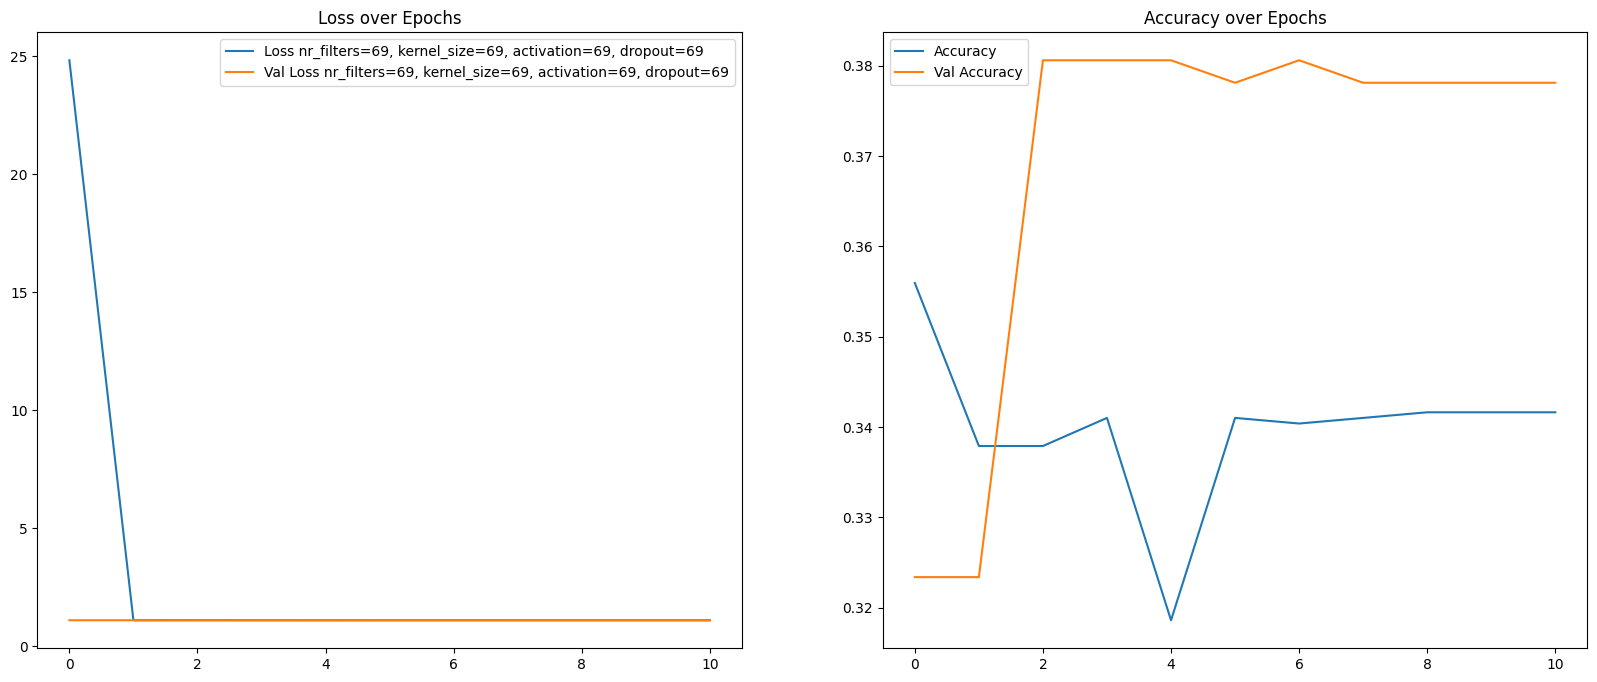

In [10]:
for label, history in histories:
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss '+label)
    plt.plot(history.history['val_loss'], label='Val Loss '+label)
    plt.legend()
    plt.title("Loss over Epochs")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy over Epochs")
    plt.show()

